In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2023-01-05 10:29:57.628217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 10:29:58.471048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-01-05 10:29:58.471163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import optax
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import stax as ostax
from flax.training.checkpoints import restore_checkpoint

import tensorflow_datasets as tfds

In [3]:
np.random.seed(42)

In [4]:
NUM_CLASSES = 10
SEED = 42

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(NUM_CLASSES)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [7]:
print(train_x.shape, test_x.shape)

(48000, 784) (12000, 784)


In [8]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

In [9]:
@dataclass(frozen=True)
class AccData:
    train_clean: float
    valid_clean: float
    train_adv: float
    valid_adv: float

In [10]:
def ntk_adv(num_iter=10, epsilon=1e-3, plot=True):

    _,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
    kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

    K_train = kernel_fn(train_x, train_x, 'ntk')
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-8 * jnp.eye(K_train.shape[0]))
    del K_train

    def predict(x_test):
        K_new = kernel_fn(train_x, x_test, 'ntk')
        return K_new.T @ K_inv @ train_y

    def loss_fn(x_test, y_test):
        pred = predict(x_test=x_test)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    def evaluate(x_test, y_test):
        pred = predict(x_test=x_test)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(y_test, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad

    def loop(x, y):
        pred, acc = evaluate(x, y)
        pred_list = [jax.device_get(pred)]
        for step in tqdm(range(num_iter)):
            x, grad = update(x, y)
            pred, acc = evaluate(x, y)
            pred_list.append(jax.device_get(pred))
        return pred_list
    
    acc_dic = dict()
    
    x_train, y_train = train_x.copy(), train_y.copy()
    pred1 = loop(x_train[:test_length], y_train[:test_length])
    pred2 = loop(x_train[test_length:], y_train[test_length:])
    pred_test = loop(test_x.copy(), test_y.copy())
    acc_train = []
    for p1, p2 in zip(pred1, pred2):
        p = np.concatenate([p1, p2])
        acc = np.mean(p == np.argmax(y_train, axis=-1))
        acc_train.append(acc)
    acc_dic['train'] = acc_train
    acc_test = []
    for p in pred_test:
        acc = np.mean(p == np.argmax(test_y, axis=-1))
        acc_test.append(acc)
    acc_dic['test'] = acc_test

    del K_inv
    return acc_dic

In [11]:
_ = ntk_adv(epsilon=3e-3)

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


In [12]:
def gauss_adv(num_iter=10, epsilon=1e-3, plot=True):
    @jax.jit
    def kernel_fn(x, y, theta1=1., theta2=1.):
        k = (
            jnp.sum(jnp.square(x), axis=1).reshape(-1, 1)
            + jnp.sum(jnp.square(y), axis=1)
            - 2 * x @ y.T
        )
        return theta1 * jnp.exp(-0.5 / theta2 * k)

    K_train = jax.device_get(kernel_fn(train_x, train_x))
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-5 * jnp.eye(K_train.shape[0]))
    del K_train

    @jax.jit
    def predict(x_test):
        K_new = kernel_fn(train_x, x_test)
        return K_new.T @ K_inv @ train_y

    @jax.jit
    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad

    def loop(x, y):
        pred, acc = evaluate(x, y)
        pred_list = [jax.device_get(pred)]
        for step in tqdm(range(num_iter)):
            x, grad = update(x, y)
            pred, acc = evaluate(x, y)
            pred_list.append(jax.device_get(pred))
        return pred_list
    
    acc_dic = dict()
    
    x_train, y_train = train_x.copy(), train_y.copy()
    pred1 = loop(x_train[:test_length], y_train[:test_length])
    pred2 = loop(x_train[test_length:], y_train[test_length:])
    pred_test = loop(test_x.copy(), test_y.copy())
    acc_train = []
    for p1, p2 in zip(pred1, pred2):
        p = np.concatenate([p1, p2])
        acc = np.mean(p == np.argmax(y_train, axis=-1))
        acc_train.append(acc)
    acc_dic['train'] = acc_train
    acc_test = []
    for p in pred_test:
        acc = np.mean(p == np.argmax(test_y, axis=-1))
        acc_test.append(acc)
    acc_dic['test'] = acc_test

    del K_inv
    return acc_dic
    

In [13]:
_ = gauss_adv(epsilon=3e-3)

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


In [14]:
def nn_adv(channels, ckpt_dir, num_iter=10, epsilon=1e-3, plot=True):

    init_fn, apply_fn = ostax.serial(
        ostax.Dense(channels),
        ostax.Relu,
        ostax.Dense(NUM_CLASSES)
    )
    
    _, init_params = init_fn(jax.random.PRNGKey(seed=SEED), (-1, 28*28))

    params = restore_checkpoint(ckpt_dir, target=init_params)

    grad_list = []

    @jax.jit
    def loss_fn(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        loss = (0.5 * (pred - test_y) ** 2).mean()
        return loss

    @jax.jit
    def evaluate(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(params, test_x, test_y):
        grad = jax.grad(loss_fn, argnums=1)(params, test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad

    def loop(x, y):
        pred, acc = evaluate(params, x, y)
        pred_list = [jax.device_get(pred)]
        for step in tqdm(range(num_iter)):
            x, grad = update(params, x, y)
            pred, acc = evaluate(params, x, y)
            pred_list.append(jax.device_get(pred))
        return pred_list
    
    acc_dic = dict()
    
    x_train, y_train = train_x.copy(), train_y.copy()
    pred1 = loop(x_train[:test_length], y_train[:test_length])
    pred2 = loop(x_train[test_length:], y_train[test_length:])
    pred_test = loop(test_x.copy(), test_y.copy())
    acc_train = []
    for p1, p2 in zip(pred1, pred2):
        p = np.concatenate([p1, p2])
        acc = np.mean(p == np.argmax(y_train, axis=-1))
        acc_train.append(acc)
    acc_dic['train'] = acc_train
    acc_test = []
    for p in pred_test:
        acc = np.mean(p == np.argmax(test_y, axis=-1))
        acc_test.append(acc)
    acc_dic['test'] = acc_test
    return acc_dic

In [15]:
_ = nn_adv(256, 'ckpt/mnist/channel_256', epsilon=3e-3)

100%|██████████| 10/10 [00:00<00:00, 452.95it/s]


In [16]:
_ = nn_adv(512, 'ckpt/mnist/channel_512', epsilon=3e-3)

100%|██████████| 10/10 [00:00<00:00, 326.13it/s]


In [17]:
label_list = ['256', '512', '1024', '2048', '4096', 'ntk', 'gauss']
epsilons = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 7.5e-3]
acc_dict = {str(eps): {l: None for l in label_list} for eps in epsilons}
for epsilon in epsilons:
    print(epsilon)
    for label in label_list:
        if label == 'ntk':
            acc_list = ntk_adv(epsilon=epsilon, plot=False)
        elif label == 'gauss':
            acc_list = gauss_adv(epsilon=epsilon, plot=False)
        else:
            channels = int(label)
            ckpt_dir = f'ckpt/mnist/channel_{channels}'
            acc_list = nn_adv(channels, ckpt_dir, epsilon=epsilon, plot=False)
        acc_dict[str(epsilon)][label] = acc_list

0.0001


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


0.0002


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


0.0005


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


0.001


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]
2023-01-05 10:39:07.749735: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: INTERNAL: Failed to allocate 1600000000 bytes for new constant


XlaRuntimeError: INTERNAL: Failed to allocate 1600000000 bytes for new constant

In [ ]:
def plot_matrix():
    fig = plt.figure(figsize=(26, 20))
    nrow = len(epsilons)
    ncol = len(label_list)
    cnt = 1
    for i, (eps, d) in enumerate(acc_dict.items()):
        for j, (model_name, accs) in enumerate(d.items()):
            plt.subplot(nrow, ncol, cnt)
            plt.plot(accs['train'], label='train')
            plt.plot(accs['test'], label='test')
            cnt += 1
            plt.grid()
            plt.legend()
            plt.ylim(0, 1)
            if i == ncol - 1:
                plt.xlabel(f'{model_name}')
            if j == 0:
                plt.ylabel(f'eps = {eps}')
    plt.show()
    plt.close()

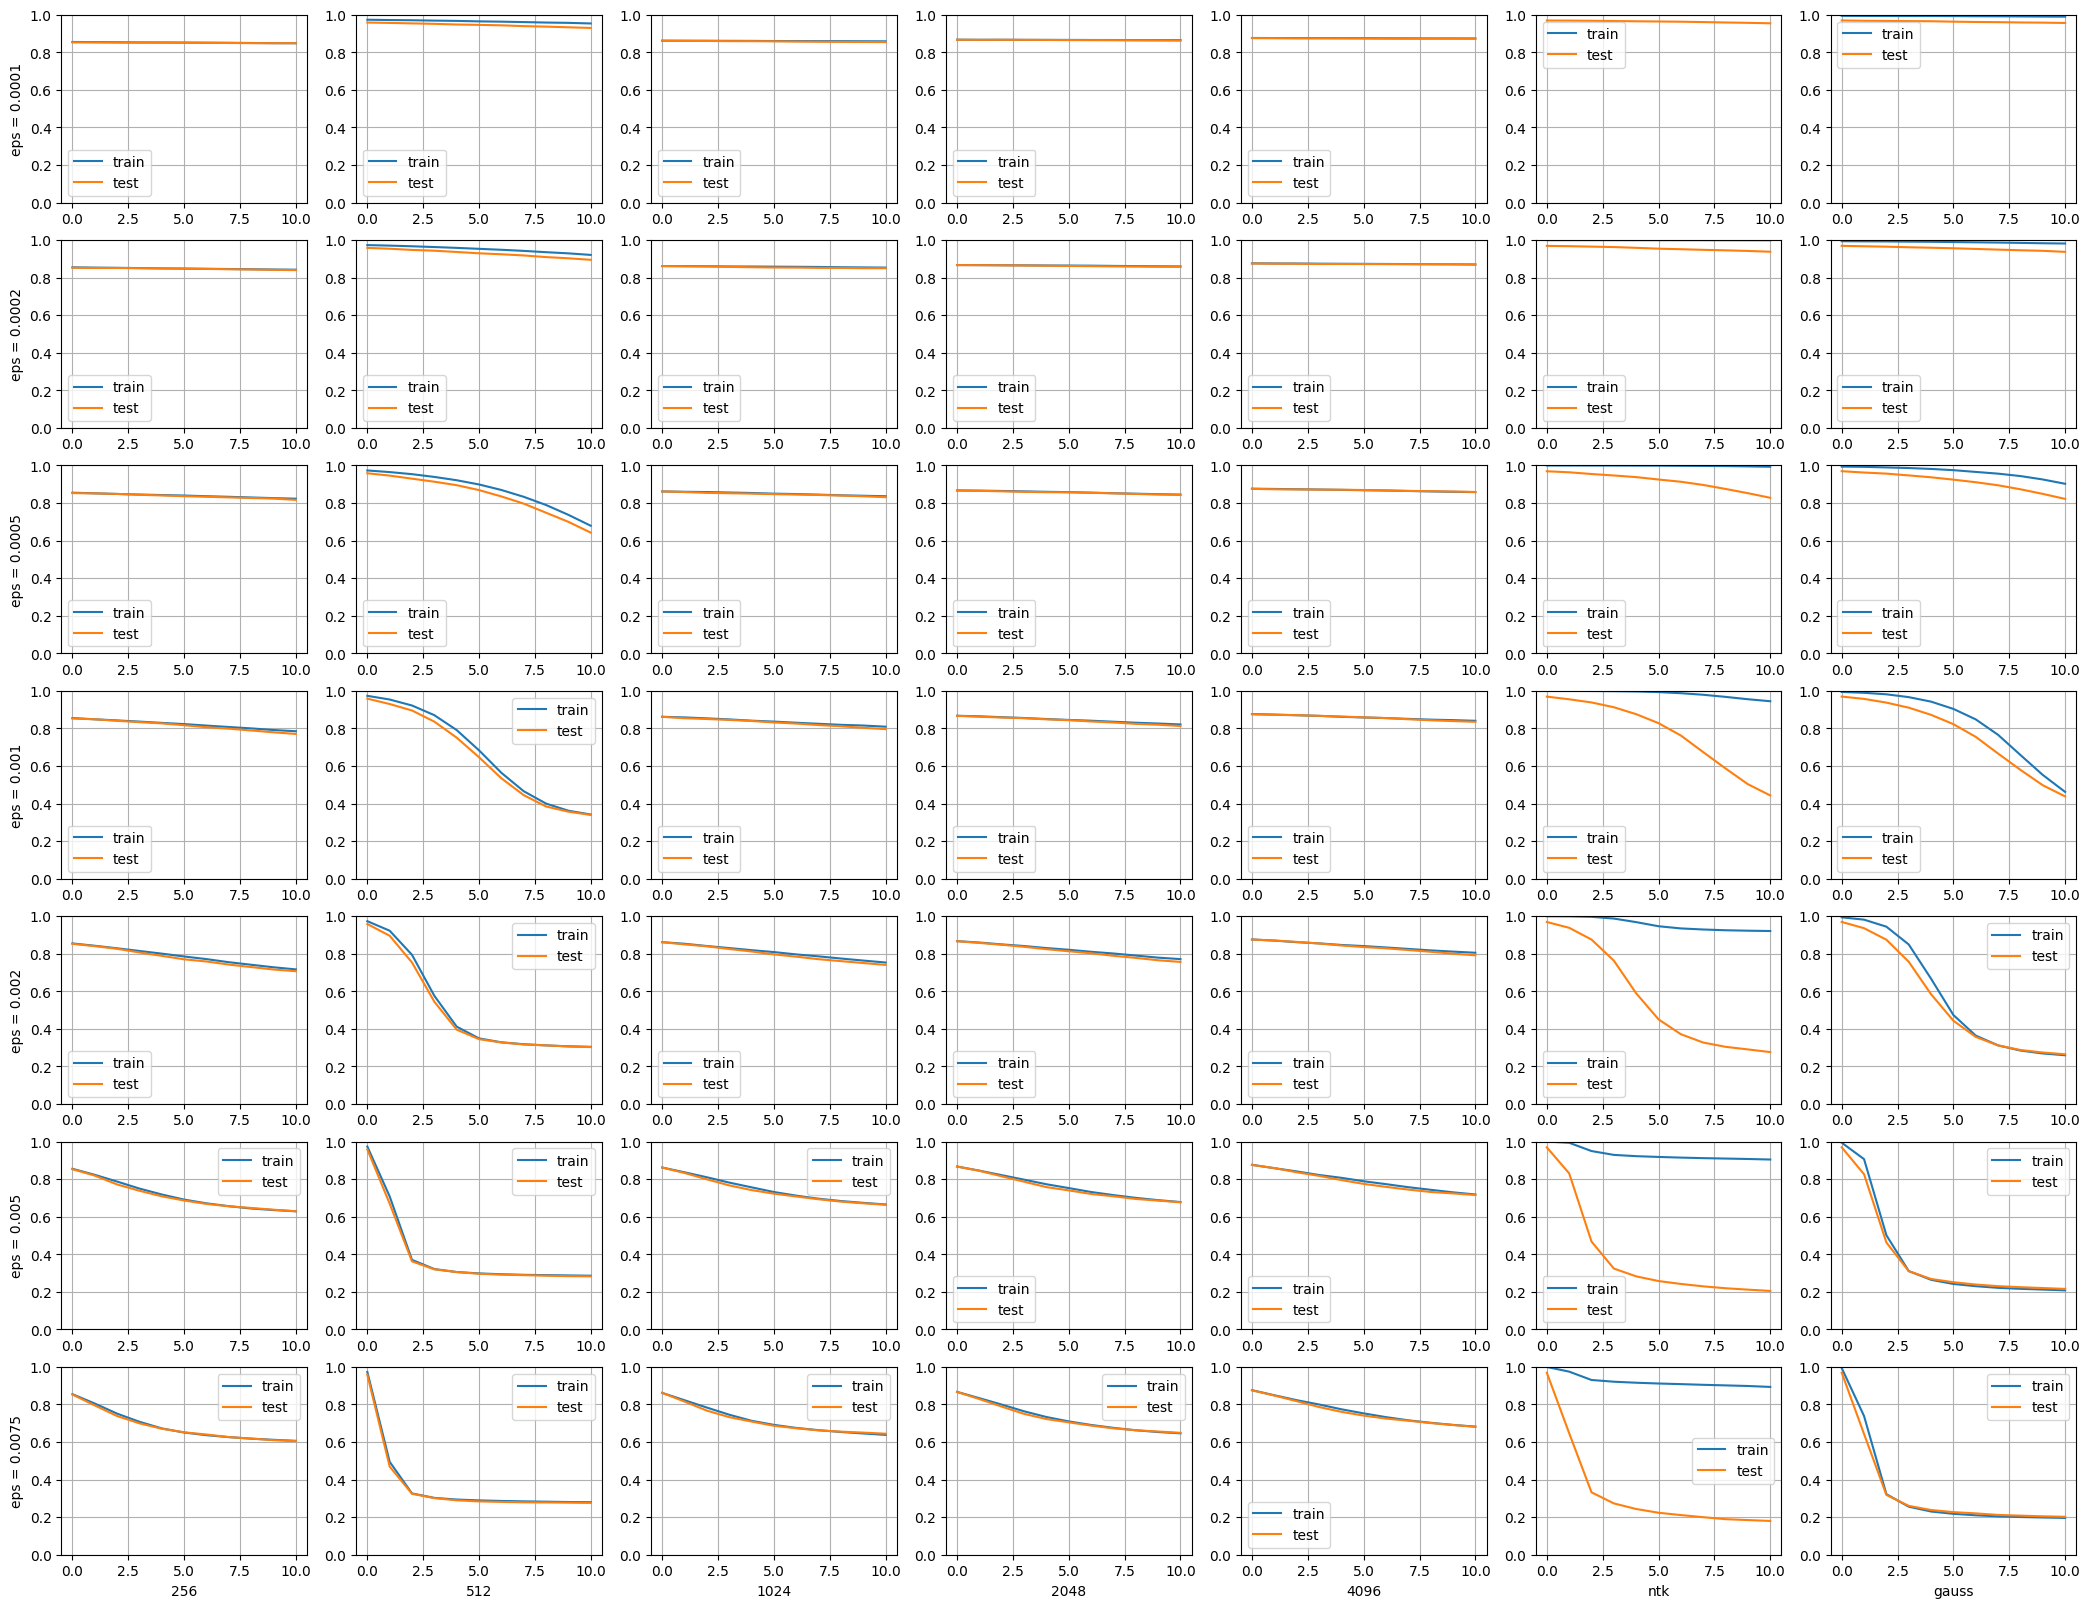

In [ ]:
plot_matrix()

In [ ]:
def plot_per_epsilon(epsilon, train=True):
    for k, v in acc_dict[str(epsilon)].items():
        vv = v['train'] if train else v['test']
        plt.plot(vv, label=k)
    plt.title(f'eps = {epsilon}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

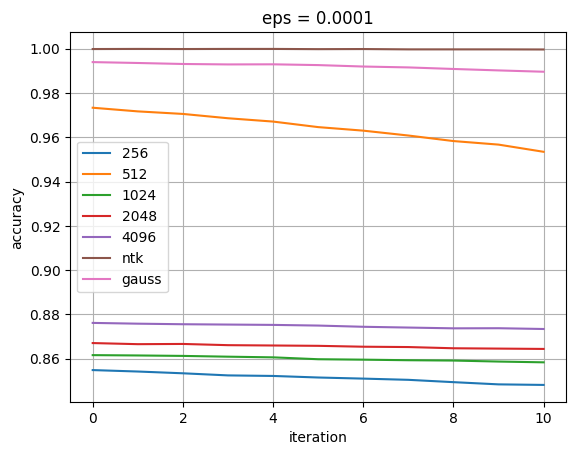

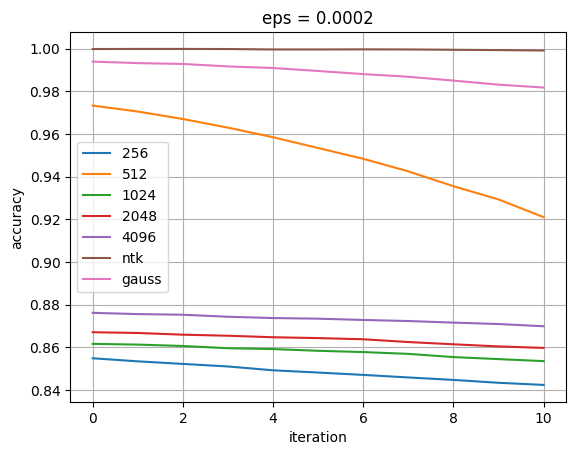

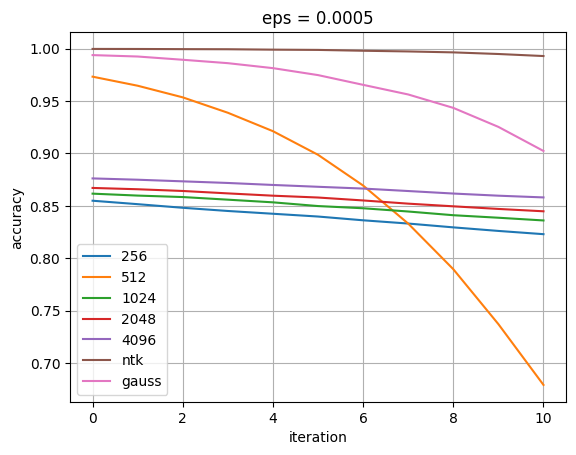

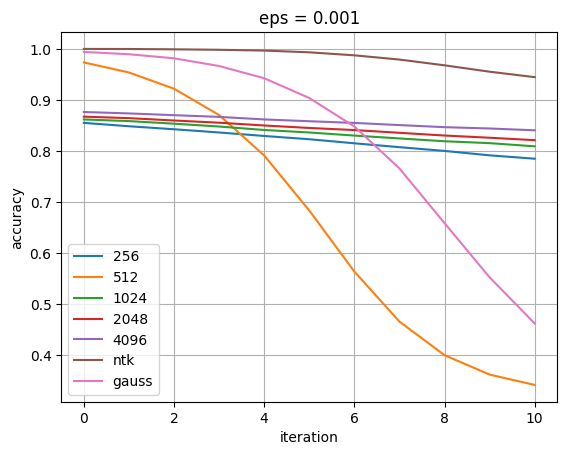

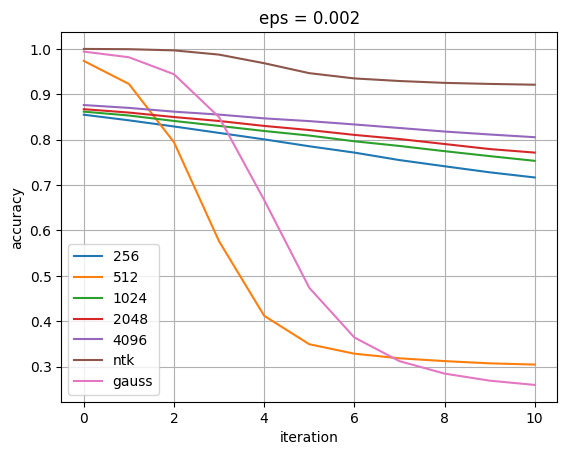

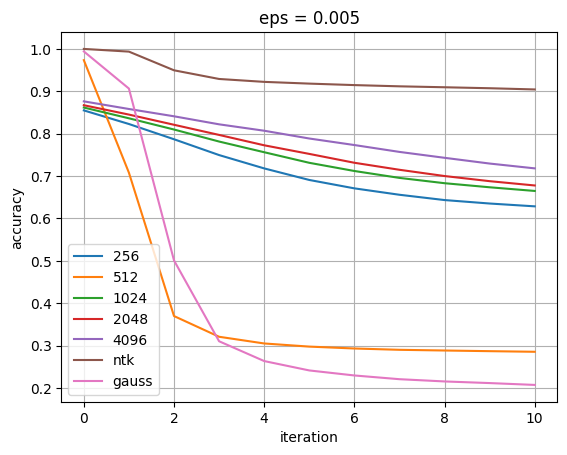

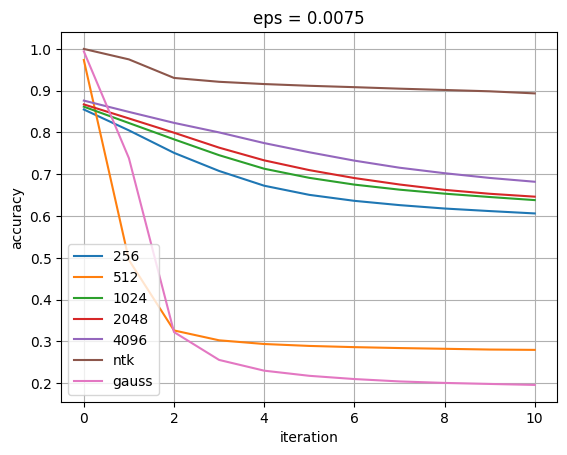

In [ ]:
for eps in epsilons:
    plot_per_epsilon(eps, train=True)

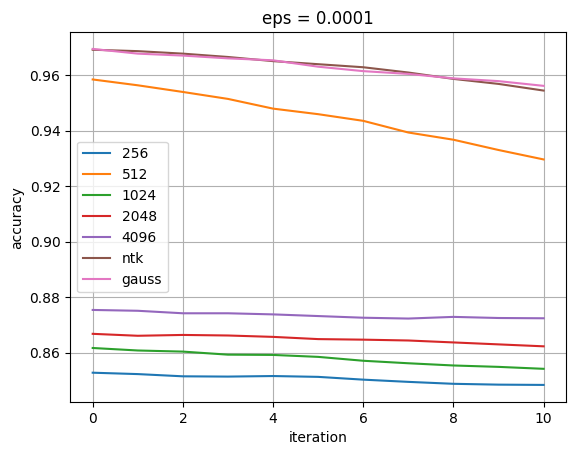

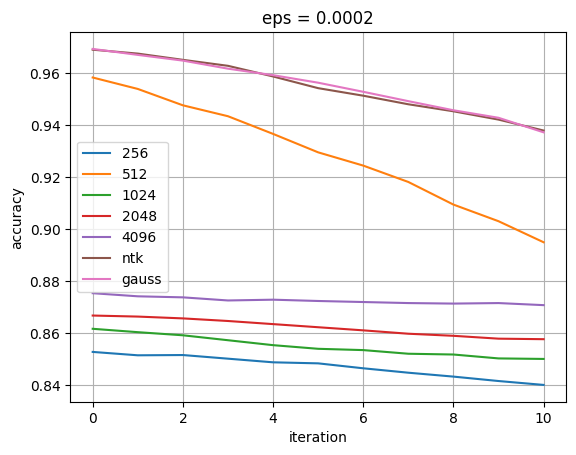

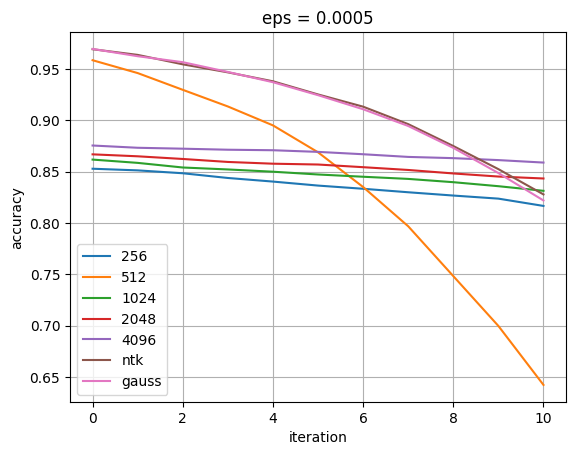

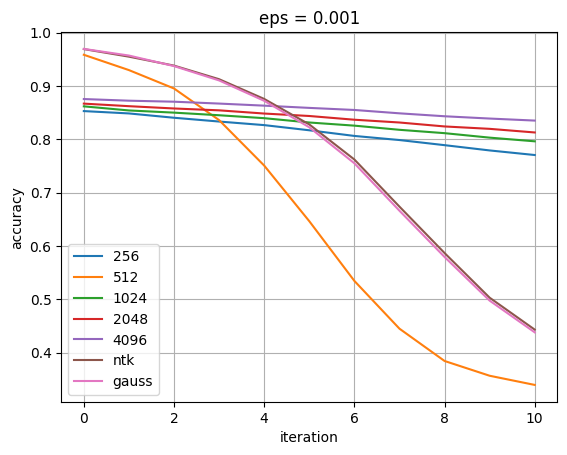

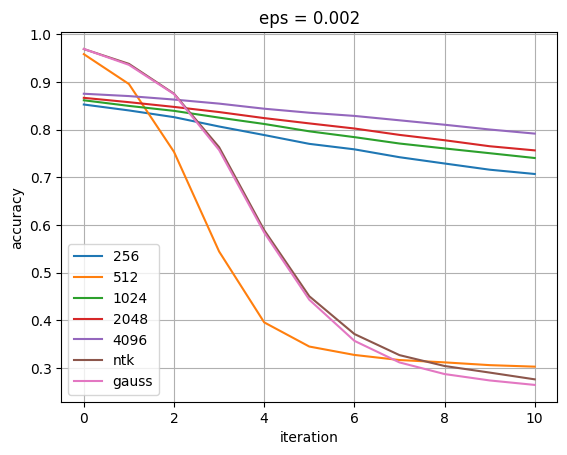

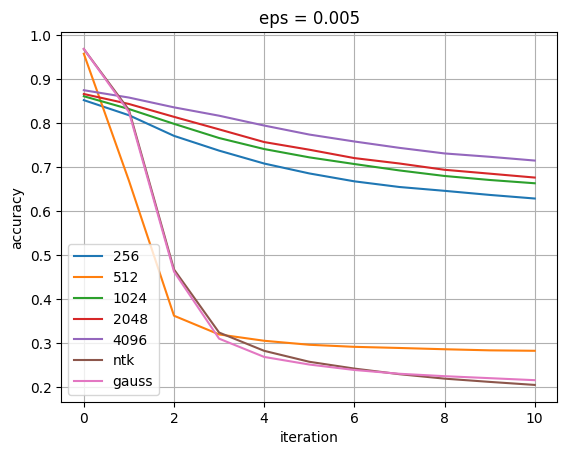

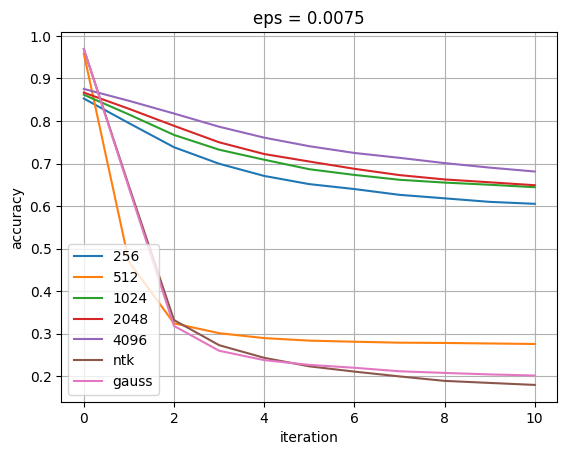

In [ ]:
for eps in epsilons:
    plot_per_epsilon(eps, train=False)

In [ ]:
def plot_per_label(label, d, train=True):
    for k, v in d.items():
        vv = v['train'] if train else v['test']
        plt.plot(vv, label=k)
    plt.title(f'{label}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()


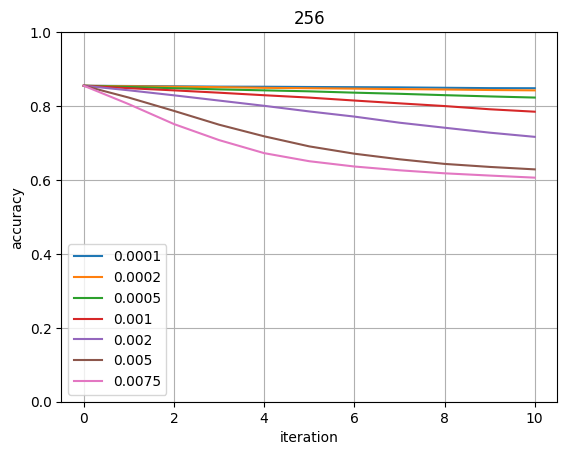

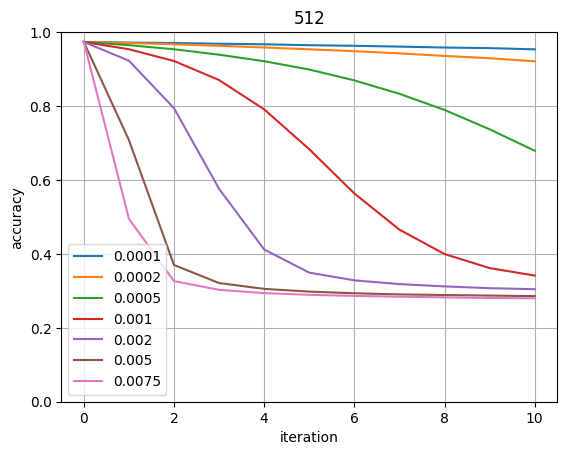

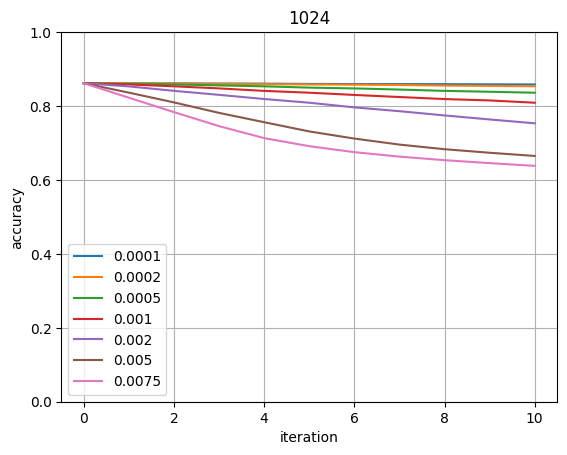

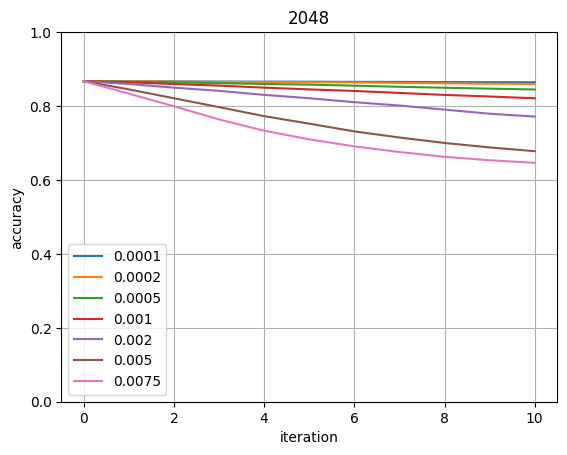

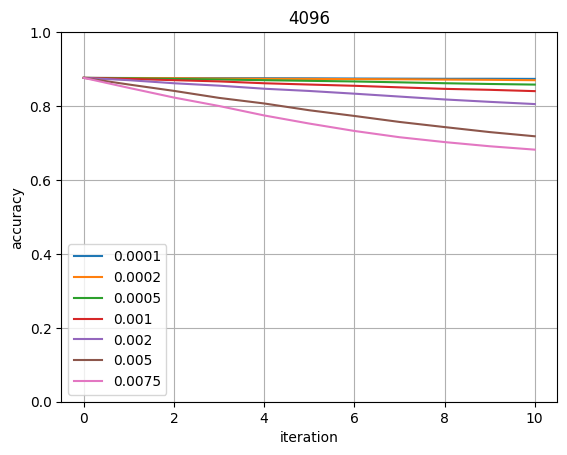

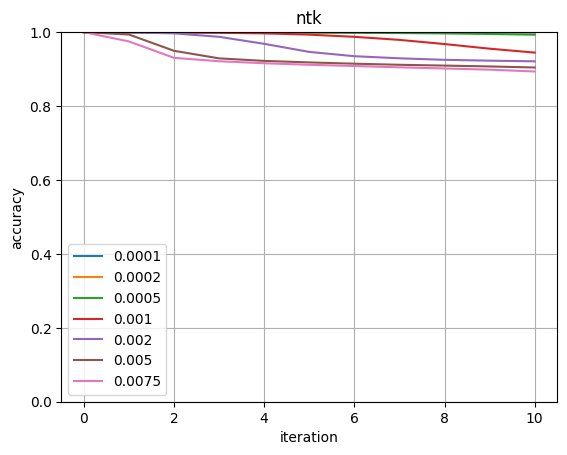

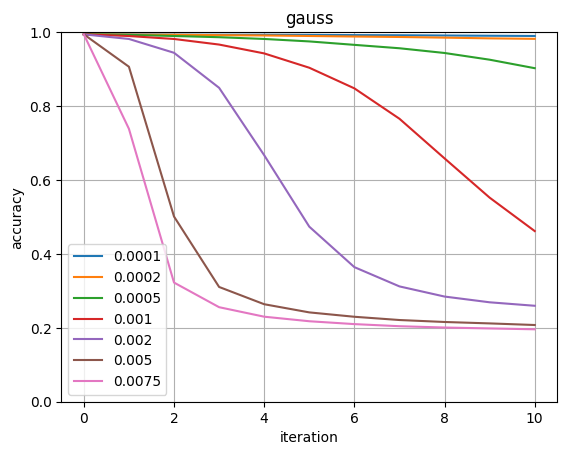

In [ ]:
for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d, train=True)

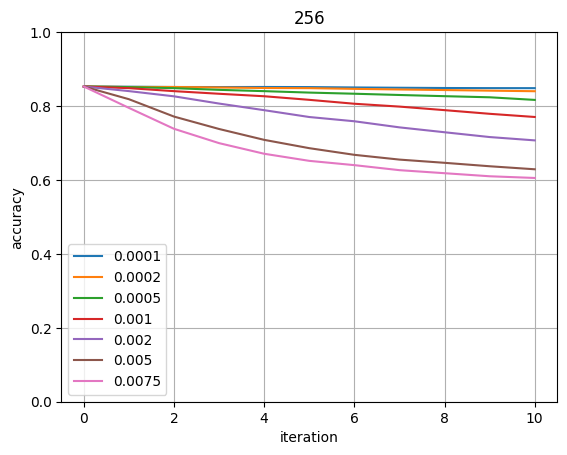

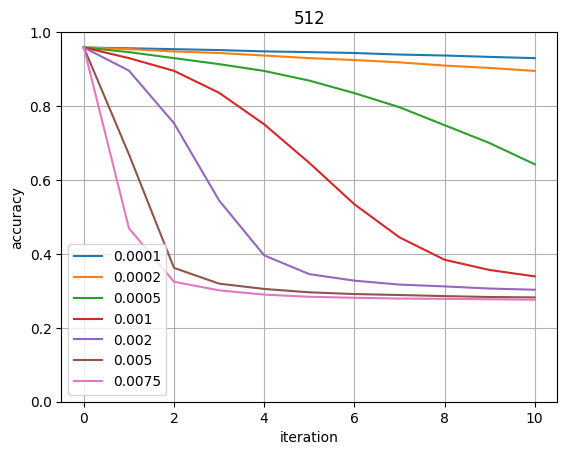

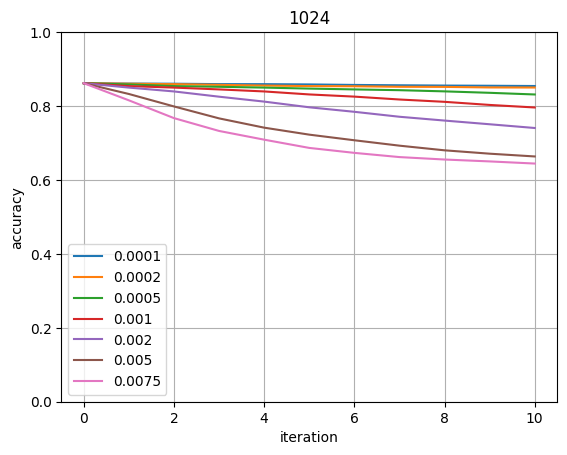

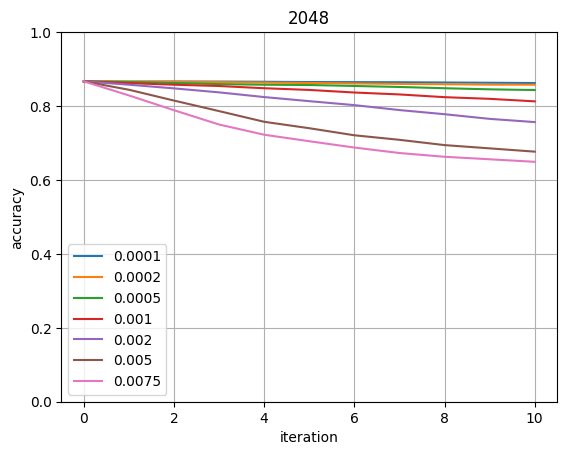

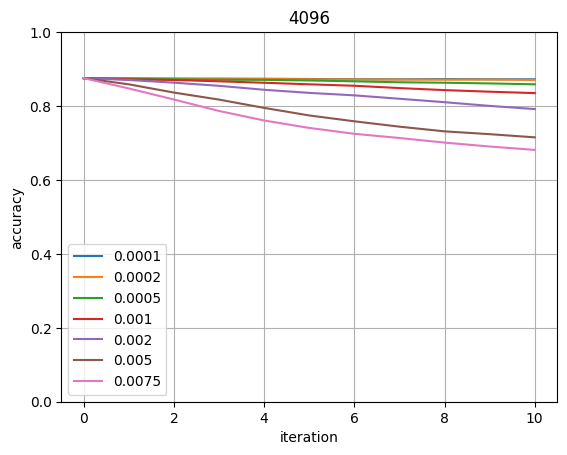

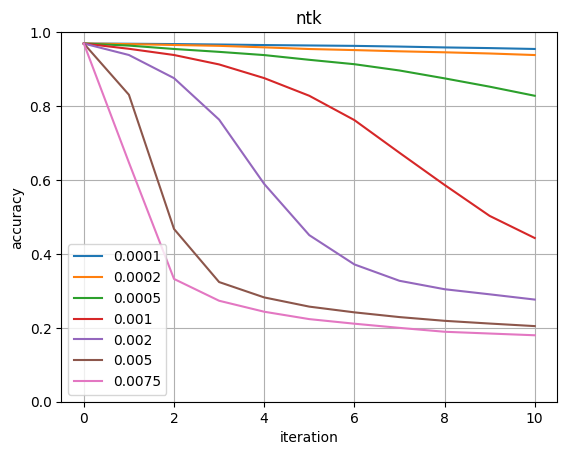

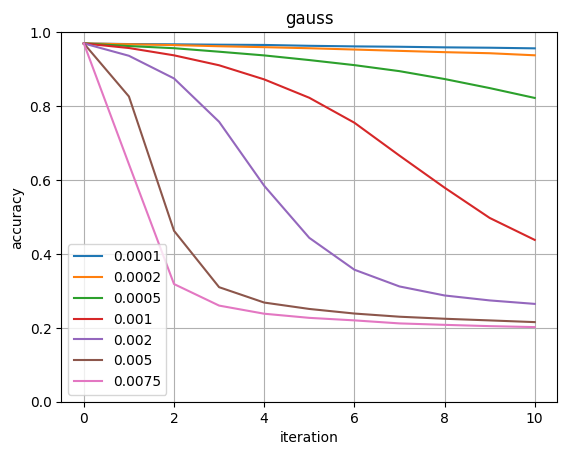

In [ ]:
for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d, train=False)